## Condition Clustering

One of the most hopeful uses of the flaredown data is to use it to identify sub-classifications of some of the conditions.

Many of the conditions being reported have treatments that work for some people but not others.  Many conditions also vary greatly in terms of the symptoms that the afflicted will experience.  This document will attempt to find clusters within some of the conditions reported on Flaredown based off of symptoms and treatment effectiveness.  The hope is to find sub-classes of conditions that can be used for a more specific diagnosis.

To start, lets do an exploratory clustering, as our recommender system may use clustering, specifically K-Means.

### Condition Clustering

Our exploration has shown that the Flaredown users are reporting heaps of conditions simultaneously.  The conditions that occur together may be interesting.  PCA may provide an informative way of looking at this.

### User Clustering
Can we find a set of features in which our users form clusters, or are we going to be looking at a fairly random distribution in the feature space?  We would like to know this as it will effect our strategy in the recommender system. Since the recommender system will need to build a seperate model for each condition, we will cluster the users on a per-condition basis, as usual starting with Depression since it is best represented at this time.

For this analysis we will start with the effectiveness data, which has already taken on some preprocessing.  It is currently in the format of one row per user/condition/treatment combination.  Since we are trying to describe our users in the case, I will extract the users affected by the condition we are currently examining, and then pivot them to one row per user.

In [20]:
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

df = pd.read_csv("effectiveness_082516.csv")
#print df.pivot_table(index=['user_id','condition'],columns='treatment',values='effectiveness')
depressed_df = df[df['condition'] == 'Depression'].pivot_table(index='user_id',columns='treatment',values='effectiveness').reset_index()
depressed_df = depressed_df.fillna(0)
print len(depressed_df.columns)

2508


Given the high number of features, I'm going to attempt PCA on this before doing any visualizations.  I can't visualize 2500 dimensions.  It's a personal failing that I'm working on.

Variance explained by 2 components 0.999971102733


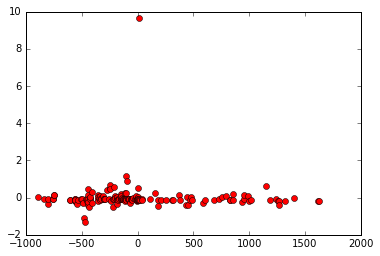

In [37]:
from sklearn.decomposition import PCA
%matplotlib inline
import matplotlib.pyplot as plt

pca = PCA(n_components=2)  #trying 2 so I can plot it
pca.fit(depressed_df)
fit_data = pca.transform(depressed_df)
print "Variance explained by 2 components " + str(np.sum(pca.explained_variance_ratio_))

plt.plot(fit_data[:,0], fit_data[:,1], 'ro')

There appears to be an outlier that we could cluster on, and maybe that group to the left could be a cluster.  But I'm concerned that it seems like almost all points are in bunched up around 0,-200.  I'm going to try K-means on the original data and check the rand score.
http://scikit-learn.org/stable/modules/generated/sklearn.metrics.adjusted_rand_score.html